Linear Discriminant Analysis seeks to best separate (or discriminate) the samples in the training dataset by their class value. Specifically, the model seeks to find a linear combination of input variables that achieves the maximum separation for samples between classes (class centroids or means) and the minimum separation of samples within each class

In [1]:
import pandas as pd
pokemon = pd.read_csv('pokemon.csv')
pokemon.head(3)

,abilities,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,...,percentage_male,pokedex_number,sp_attack,sp_defense,speed,type1,type2,weight_kg,generation,is_legendary
0,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,1,65,65,45,grass,poison,6.9,1,0
1,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,2,80,80,60,grass,poison,13.0,1,0
2,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,3,122,120,80,grass,poison,100.0,1,0


In [2]:
df = pokemon[pokemon['type2'].isnull()].loc[
    :, ['sp_attack', 'sp_defense', 'attack', 'defense', 'speed', 'hp', 'type1']
]
X = df.iloc[:, :-1].values

from sklearn.preprocessing import normalize
X_norm = normalize(X)

y = df.iloc[:, -1].values

In [3]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(n_components=3)
lda.fit(X_norm, y)

LinearDiscriminantAnalysis(n_components=3)

# Assessing class-wise variable importance using LDA coefficients

PCA provides a components_ attribute to the fitted reducer, which allows us to directly access the vector components. LDA does not provide this attribute. This is because in LDA, the methodology for transforming a vector is a bit more complicated than a simple w.T * x reprojection.

An LDA instead provides a coef_ attribute, which is analogous, albeit more mathematically complicated. The magnitudes of the components in the coef_ tell us how heavily each of the features loads towards the seperability of that class.

If a particular class has a particularly high-magnitude coefficient (direction, positive or negative, notwithstanding) then that variable signals that class very well. That variable will factor very heavily into the LDA preprojection. A low-magnitude coefficient, meanwhile, corresponds with a weak signal, and hence will be mostly rubbed out in the reprojection.

If a class has mostly low-magnitude coefficients, that means that it is not easily linearly separable! That class is relatively close to the mean of the dataset or (in the weaker cases) relatively close to a subset of other classes in the dataset.

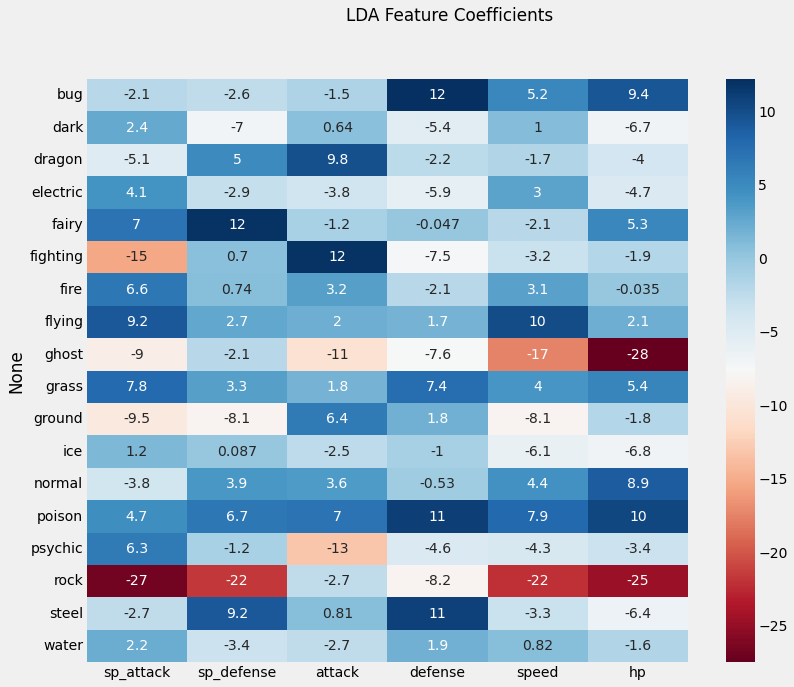

In [4]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import numpy as np

fig, ax = plt.subplots(1, 1, figsize=(12, 10))

sns.heatmap(pd.DataFrame(lda.coef_, 
                         columns=df.columns[:-1], 
                         index=[lda.classes_]), 
            ax=ax, cmap='RdBu', annot=True)

plt.suptitle('LDA Feature Coefficients')
pass

A good example of a separable class is the rock type. Rock type Pokemon load very strongly on all of Special Attack, Special Defense, Speed, and HP, implying that a combination of these stats makes up the Rock archetype. Other highly separable classes are the ghost type and the fighting type, which both sport some high-magnitude coefficients.

ice and water are two classes that have very low class separability. They both have coefficients that are mostly close to 0.

We can summarize this heatmap by looking at the absolute coefficient totals for each of the classes.

<AxesSubplot:title={'center':'LDA Class Coefficient Sums'}>

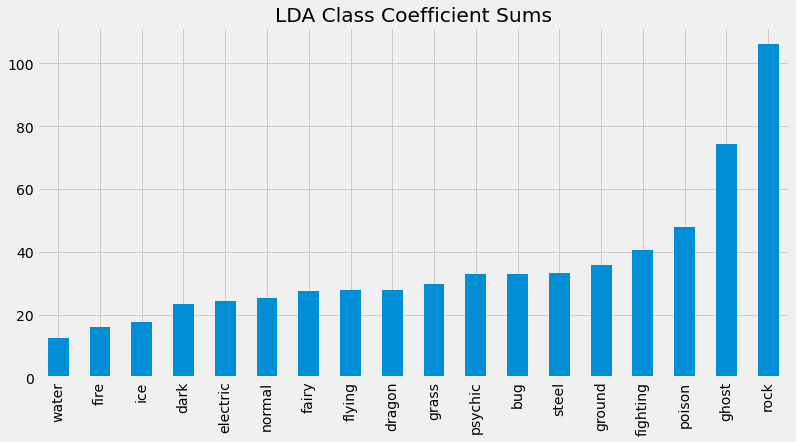

In [5]:
pd.Series(np.abs(lda.coef_).sum(axis=1), index=lda.classes_).sort_values().plot.bar(
    figsize=(12, 6), title="LDA Class Coefficient Sums"
)

Again, we see that rock and ghost is much more separable than water and ice.

The y-values in both the heatmap and the bar plot can be treated as indicial. Higher is better, but the numbers themselves are not particularly interpretable (at least, my math isn't strong enough to interpret them immediately; feel free to think otherwise in the comments).

To see what this difference translates to and to understand how well we perform overall, we need to move on to applying our LDA.

# Assessing linear classifier performance by applying the LDA projection

To start with, as with any dimensionality reduction technique, it's important to note that each additional component used by the model adds less and less "gain" to the reconstructions. For example, here are the top three explained variances of the LDA decomposition:

In [6]:
lda.explained_variance_ratio_

array([0.48036548, 0.21001446, 0.13047873])

# PCA picks values which maximize these values directly. LDA picks values that maximize the differences between classes

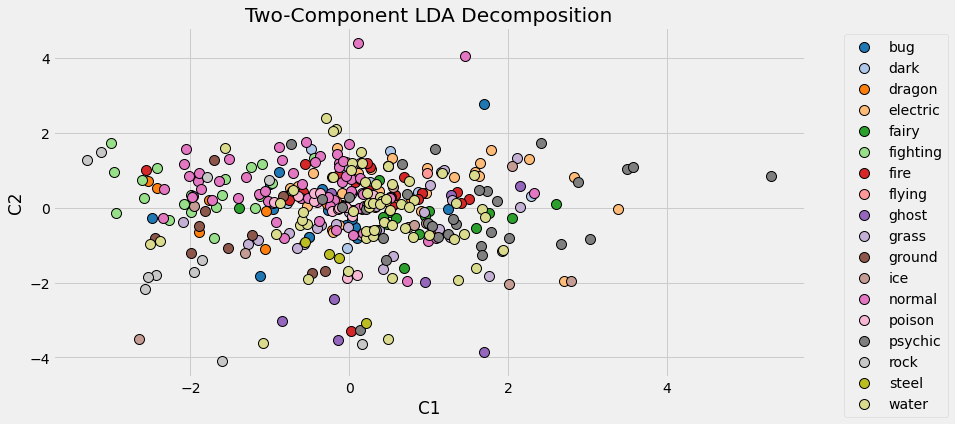

In [7]:
X_hat = lda.fit_transform(X, y)

import matplotlib as mpl

colors = mpl.cm.get_cmap(name='tab20').colors
categories = pd.Categorical(pd.Series(y)).categories
ret = pd.DataFrame(
    {'C1': X_hat[:, 0], 'C2': X_hat[:, 1], 'Type': pd.Categorical(pd.Series(y))}
)

fig, ax = plt.subplots(1, figsize=(12, 6))

for col, cat in zip(colors, categories):
    (ret
         .query('Type == @cat')
         .plot.scatter(x='C1', y='C2', color=col, label=cat, ax=ax,
                       s=100, edgecolor='black', linewidth=1,
                       title='Two-Component LDA Decomposition')
         .legend(bbox_to_anchor=(1.2, 1))
    )